### THE ANATOMY OF A WILDFIRE

Running query to get statistics for 2003-2015...
Query complete. Here are the new statistics:
                    name    count       average  std_deviation  min_value  \
0       EPM2_5_emissions  9534789     26.213199      36.271827        0.0   
1            area_burned  9534789  42306.435675   29228.715671        0.0   
2          burning_index  9533446     47.729671      28.020551        0.0   
3          consumed_fuel  9534789   1490.834725    1735.905676        0.0   
4   fuel_moisture_1000hr  9533446     11.749630       4.864778        2.2   
5        max_temperature  9533446    300.039917       7.355737      253.5   
6  min_relative_humidity  9533446     23.181171      14.092642        0.7   

         median     max_value  
0      3.306701    238.889137  
1  62500.000000  62500.000000  
2     49.000000    171.000000  
3    324.186338  10477.593715  
4     10.700000     36.700001  
5    300.799988    321.899994  
6     19.600000    100.000000  

Generating Average vs. Median co

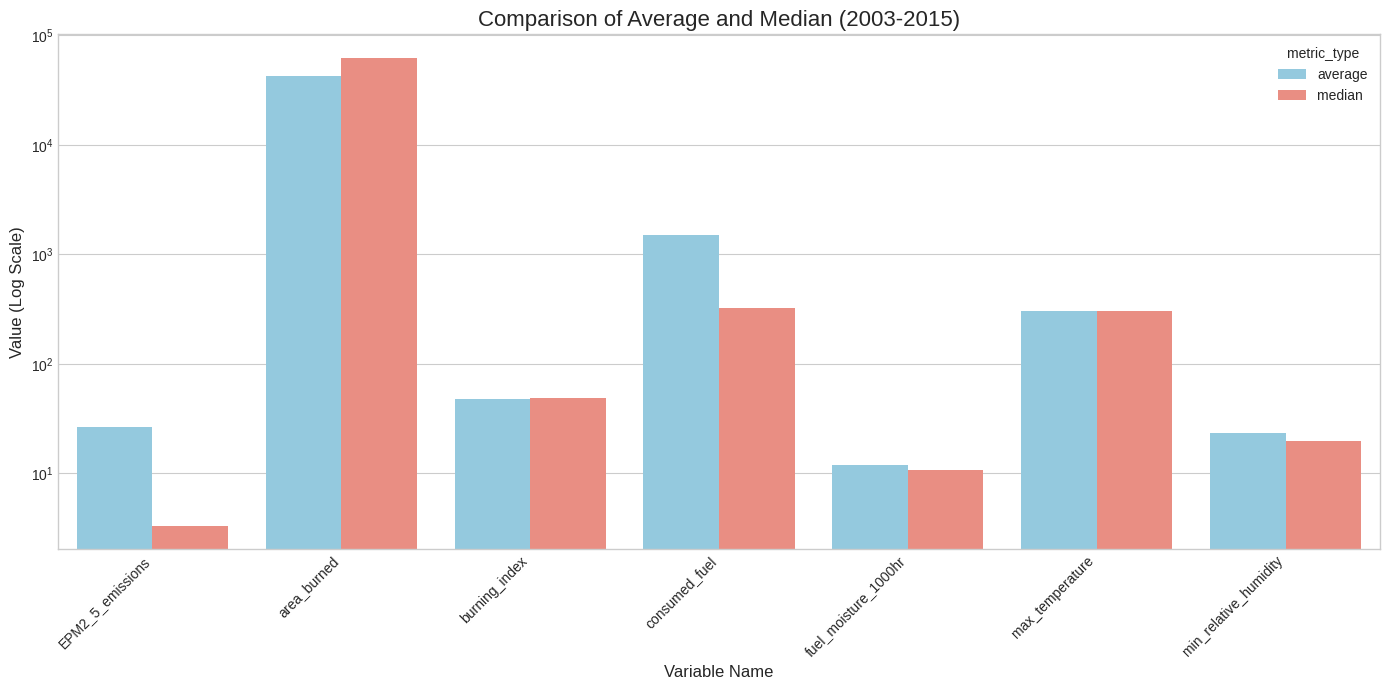


Generating Standard Deviation comparison plot...


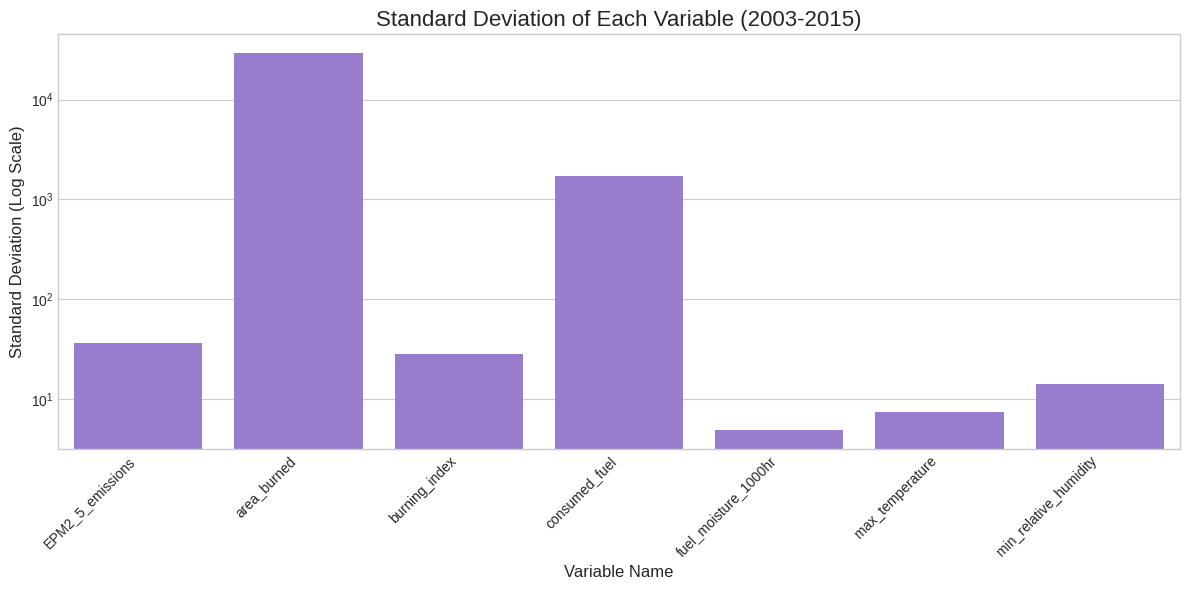

In [ ]:
# 1. Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.cloud import bigquery

# --- Configuration ---
PROJECT_ID = "code-for-planet"
DATASET_ID = "emission_db"

# --- Part 1: Run the BigQuery query to get 2003-2015 statistics ---

# Initialize the BigQuery client
# Make sure you have authenticated in your environment (e.g., Google Colab)
client = bigquery.Client(project=PROJECT_ID)

# SQL query to calculate descriptive statistics for the full 2003-2015 period
sql_query = """
WITH metrics AS (
 SELECT
   area_burned,
   consumed_fuel,
   EPM2_5,
   tmmx_value AS max_temperature,
   rmin_value AS min_relative_humidity,
   fm1000_value AS fuel_moisture_1000hr,
   bi_value AS burning_index
 FROM
   `code-for-planet.emission_db.emission_*` -- Using a wildcard to select all tables
 WHERE
   _TABLE_SUFFIX BETWEEN '2003' AND '2015' -- Filtering for the correct years
),
calculations AS (
 SELECT
   metric.name,
   COUNT(metric.value) AS count,
   AVG(metric.value) AS average,
   STDDEV(metric.value) AS std_deviation,
   MIN(metric.value) AS min_value,
   APPROX_QUANTILES(metric.value, 4 IGNORE NULLS)[OFFSET(2)] AS median,
   MAX(metric.value) AS max_value
 FROM
   metrics,
   UNNEST([
     STRUCT('area_burned' AS name, area_burned AS value),
     STRUCT('consumed_fuel' AS name, consumed_fuel AS value),
     STRUCT('EPM2_5_emissions' AS name, EPM2_5 AS value),
     STRUCT('max_temperature' AS name, max_temperature AS value),
     STRUCT('min_relative_humidity' AS name, min_relative_humidity AS value),
     STRUCT('fuel_moisture_1000hr' AS name, fuel_moisture_1000hr AS value),
     STRUCT('burning_index' AS name, burning_index AS value)
   ]) AS metric
 GROUP BY
   metric.name
)
SELECT * FROM calculations ORDER BY name;
"""

print("Running query to get statistics for 2003-2015...")
# Execute the query and load the results directly into a DataFrame
df_stats = client.query(sql_query).to_dataframe()
print("Query complete. Here are the new statistics:")
print(df_stats)


# --- Part 2: Use the new DataFrame to generate visualizations ---

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')

# Visualization 1: Average vs. Median (Comparing Skewness)
print("\nGenerating Average vs. Median comparison plot...")
df_melted = df_stats.melt(id_vars='name', value_vars=['average', 'median'],
                         var_name='metric_type', value_name='value')
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_melted, x='name', y='value', hue='metric_type', palette=['skyblue', 'salmon'])
ax.set_yscale('log')
ax.set_title('Comparison of Average and Median (2003-2015)', fontsize=16)
plt.xlabel('Variable Name', fontsize=12)
plt.ylabel('Value (Log Scale)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 2: Standard Deviation (Comparing Variability)
print("\nGenerating Standard Deviation comparison plot...")
plt.figure(figsize=(12, 6))
ax_std = sns.barplot(data=df_stats, x='name', y='std_deviation', color='mediumpurple')
ax_std.set_yscale('log')
ax_std.set_title('Standard Deviation of Each Variable (2003-2015)', fontsize=16)
plt.xlabel('Variable Name', fontsize=12)
plt.ylabel('Standard Deviation (Log Scale)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()